In [1]:
### Import the packages required for analysis and visualisation

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib as mpl
mpl.rcParams['mpl_toolkits.legacy_colorbar'] = False
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import AxesGrid

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
### Load the data

confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recovered = pd.read_csv('data/time_series_19-covid-Recovered.csv')

populations = pd.read_csv('data/population-figures-by-country-csv_csv.csv')

country_codes = pd.read_csv('data/country_codes.csv')

In [3]:
# Pull the coordinates for each country and keep in a separate dataframe

coords = confirmed[['Country/Region', 'Lat', 'Long']].groupby('Country/Region').mean()
# A couple of colonial countries aren't amenable to aggregating their coordinates...
coords.loc['United Kingdom']['Lat'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Lat']
coords.loc['United Kingdom']['Long'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Long']
coords.loc['Netherlands']['Lat'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Lat']
coords.loc['Netherlands']['Long'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Long']

# Use groupby to sum the number of cases for countries that are listed with more than one territory, then drop the lat/long columns
# .T to transpose from wide to long

confirmed = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
recovered = recovered.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
deaths = deaths.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T

# Convert the indices to datetime
confirmed.index = pd.to_datetime(confirmed.index)
recovered.index = pd.to_datetime(recovered.index)
deaths.index = pd.to_datetime(deaths.index)

In [4]:
covid_cases = pd.concat([confirmed, recovered, deaths], axis=1, keys=['confirmed', 'recovered', 'deaths']).sort_index(axis=1)

In [5]:
num_missing = covid_cases.isna().to_numpy().sum()

print(f"There are {num_missing} missing datapoints.")

There are 0 missing datapoints.


In [6]:
# Fill up to 5 missing values between two known values

covid_cases.interpolate(method='time', axis=0, limit=5, limit_area = 'inside', inplace=True)

In [7]:
## Set the most recent date in the dataset, this will change as more dates/data is added

most_recent_date = covid_cases.index[-1]
first_date = covid_cases.index[0]

total_countries = (covid_cases.loc[most_recent_date]['confirmed']).shape[0]

print(f"The data available on reported COVID cases extends from {first_date.date()} to {most_recent_date.date()}.")
print(f"A total of {total_countries} countries have reported data on COVID cases.")

The data available on reported COVID cases extends from 2020-01-22 to 2020-03-19.
A total of 155 countries have reported data on COVID cases.


In [8]:
## Select confirmed cases for all countries and the most recent date in the dateime index, this will work even when more dates are added
## Check to see if there are more than 10 cases (forms boolean series), then add them together

no_countries_over10 = (covid_cases.loc[most_recent_date]['confirmed'] > 10).sum()

print(f"{no_countries_over10} countries have reported more than 10 cases out of a total of {total_countries} countries reporting data.")

110 countries have reported more than 10 cases out of a total of 155 countries reporting data.


In [9]:
## Add a separate multi-indexed column for active cases for each country, this is easiest done with stack/unstack

covid_cases = covid_cases.stack()
covid_cases['active'] = np.nan
covid_cases = covid_cases.unstack()

## Calculate active cases by active = confirmed - (recovered + deaths)
covid_cases['active'] = covid_cases['confirmed'] - (covid_cases['recovered'] + covid_cases['deaths'])

In [10]:
print("The five countries with the highest number of active cases are:")
for count, i in enumerate(covid_cases.loc[most_recent_date]['active'].T.sort_values(ascending=False)[:5].iteritems()):
    print(f'{count+1}. {i[0]} with {i[1]} active cases.')

The five countries with the highest number of active cases are:
1. Italy with 33190 active cases.
2. Spain with 16026 active cases.
3. Germany with 15163 active cases.
4. US with 13477 active cases.
5. Iran with 11413 active cases.


In [11]:
# Calculate the weekly rate of change over the last week of data

week_change = covid_cases['confirmed'].iloc[-7:].sum(axis=1)[6] - covid_cases['confirmed'].iloc[-7:].sum(axis=1)[0]

print(f"In the last week of data, the number of confirmed cases has increased globally by {week_change}.")

In the last week of data, the number of confirmed cases has increased globally by 97515.


\section{Data normalisation}

In [12]:
### Add the required columns to out dataframe

covid_cases = covid_cases.stack()
covid_cases['confirmed_per_million'] = np.nan
covid_cases['recovered_per_million'] = np.nan
covid_cases['deaths_per_million'] = np.nan
covid_cases['active_per_million'] = np.nan
covid_cases['days_since_ten'] = np.nan
covid_cases = covid_cases.unstack()

In [13]:
# Not every country as their populaton reported at the same time (see eritrea in csv), although every country in the current dataset has a 2016 population recorded
# Not ever country (e.g. Cruise Ship and Holy See) have a population
# Our loop needs to be able to handle this

country_list = covid_cases['active'].columns

for i in country_list:
    
    # Calculate cases per million for each country
    try:
        code = country_codes[country_codes.Country == i]['Country_Code'].iloc[0]
        country_populations = populations[populations.Country_Code == code].T
        millions = country_populations.loc[country_populations.last_valid_index()].item() / 1000000
    except Exception as e:
        print(e)
        print("Couldn't find population for " + i + " filling with NaN")
        millions = np.nan

    covid_cases.loc[:, ('confirmed_per_million', i)] = covid_cases.loc[:, ('confirmed', i)] / millions
    covid_cases.loc[:, ('recovered_per_million', i)] = covid_cases.loc[:, ('recovered', i)] / millions
    covid_cases.loc[:, ('deaths_per_million', i)] = covid_cases.loc[:, ('deaths', i)] / millions
    covid_cases.loc[:, ('active_per_million', i)] = covid_cases.loc[:, ('active', i)] / millions
    
    # Now calculate the days since 10 confirmed cases were reported
    
    mask = covid_cases['confirmed'][i] >= 10 # Create a boolean mask
    idx = next(iter(mask.index[mask]), np.nan) # Get the index (date) of the first true value in the boolean mask
    if pd.isnull(idx):
        covid_cases.loc[:,('days_since_ten', i)] = np.nan # If a country never reached 10 cases days_since_ten = np.nan
    else:
        covid_cases.loc[:,('days_since_ten', i)] = (covid_cases['confirmed'][i].index - idx).days # Subtract the datetime index from all the dates to give us "day since"
    

None
Couldn't find population for Cruise Ship filling with NaN
None
Couldn't find population for Holy See filling with NaN


\section{Further data exploration}

\subsection{Which countries appear to be past the peak of their local outbreak?}

In [14]:
# List the countires had their highest daily active cases prior to the end date of the data

past_peak = []

for i in country_list:
    if covid_cases['active'][i][::-1].idxmax() < most_recent_date: # Find the date that the highest active cases occurred on and check if it was before the latest date
        print(i)
        past_peak.append(i)

Algeria
China
Cruise Ship
Greece
Korea, South
Nepal


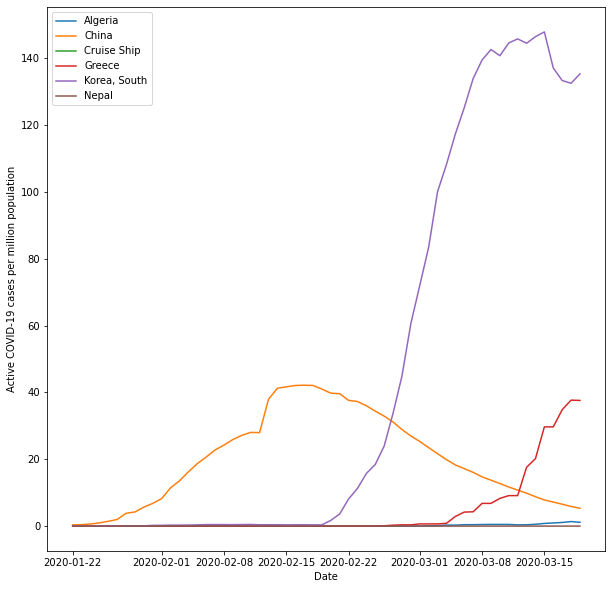

In [15]:
plt.figure(figsize=(10,10))
plt.xlabel("Date")
plt.ylabel("Active COVID-19 cases per million population")

for i in past_peak:
    plt.plot(covid_cases['active_per_million'][i], label=i)
       
plt.legend()

plt.show()

Following visual inspection:
- China and South Korea appear to be definitively passed their peak
- Greece may have passed their peak, but it's difficult to definitively say
- Algeria and Nepal both have small case numbers, which make it difficult to interpret the peak
- Cruise Ships are not a country

\subsection{What can you say about how long it takes for the outbreak to peak?}
We can only confidently identify the peak with reasonable confidence in China, South Korea and Greece.

In [16]:
peaked = ['China', 'Korea, South', 'Greece']

days_to_peak = []

for i in peaked:
    peak_idx = covid_cases['active'][i][::-1].idxmax() 
    days_to_peak.append(covid_cases.loc[peak_idx, ('days_since_ten', i)])
    
mean_days_to_peak = np.mean(days_to_peak)
std_days_to_peak = np.std(days_to_peak)

print(f"Of the three countries to have peaked the peak occured {np.round(mean_days_to_peak, 2)} ± {np.round(std_days_to_peak, 2)} days after reaching 10 confirmed cases.")

Of the three countries to have peaked the peak occured 27.67 ± 12.71 days after reaching 10 confirmed cases.


In [17]:
first_recovery = pd.DataFrame(index = covid_cases.confirmed.columns, columns=['time_to_first_recovery'])

for country in covid_cases.confirmed.columns:
    temp_conf = covid_cases.confirmed[country].replace(0, np.nan)
    temp_recov = covid_cases.recovered[country].replace(0, np.nan)
    if temp_conf.loc[temp_conf.first_valid_index()] < 10: # Skip countries that had significant cases prior to data availability
        first_reported = temp_conf.first_valid_index()
        first_recovered = temp_recov.first_valid_index()
        
        if pd.notnull(first_recovered):
            first_recovery.loc[country, 'time_to_first_recovery'] = (first_recovered - first_reported).days
            

first_recovery.time_to_first_recovery = first_recovery.time_to_first_recovery.astype('float')


In [18]:
first_recovery.describe()

,time_to_first_recovery
count,79.000000
mean,12.607595
std,5.268235
min,4.000000
25%,9.500000
50%,12.000000
75%,16.000000
max,38.000000


\subsection{Mitigation strategies are aimed at 'flattening' the outbreak, to reduce the strain on the health system. We discuss this in more detail in the concluding remarks below. For countries or regions that are far enough into their local outbreak, consider the number of active cases relative to the number of confirmed cases. Can you say anything about the effectiveness of their mitigation strategies?}

In [19]:
# Add column for active / confirmed ratio + rolling average

covid_cases = covid_cases.stack()
covid_cases['active_confirmed_ratio'] = np.nan
covid_cases['active_confirmed_ratio_7day_rolling'] = np.nan
covid_cases = covid_cases.unstack()

# Calculate the ratio of active cases per confirmed cases
covid_cases['active_confirmed_ratio'] = covid_cases['active'] / covid_cases['confirmed']
covid_cases['active_confirmed_ratio_7day_rolling'] = covid_cases['active_confirmed_ratio'].rolling(7).mean()

In [20]:
# Create a list of countries that have 30 days of data since 10 cases and at least 250 reported cases
at_least_30_days = []

for country in covid_cases['days_since_ten'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 250:
        if covid_cases.loc[most_recent_date, ('days_since_ten', country)].item() > 30 and country != 'Cruise Ship':
            at_least_30_days.append(country)
            
print(f"There are {len(at_least_30_days)} countries with 30 days of data after their 10th case and more than 250 total cases reported.")

There are 10 countries with 30 days of data after their 10th case and more than 250 total cases reported.


We can now compare the most recent 7-day rolling average ratio of active to confirmed cases for the countries identified.

In [21]:
# Examine the change in this ratio over the 20 days since 10 cases
# As we are looking at the 7 day rolling mean, the first value will begin on day 7 following the first 10 cases

ratio_df = pd.DataFrame(index=at_least_30_days, columns = ['latest_ratio'])

for country in at_least_30_days:
    country_df = covid_cases.loc[:, (slice(None), country)].droplevel(axis=1,level=1).set_index('days_since_ten')
    most_recent_ratio = country_df['active_confirmed_ratio_7day_rolling'].iloc[-1]
    ratio_df.loc[country, 'latest_ratio'] = most_recent_ratio
    
print("\nThe three countries with the most suppression of active cases compared to confirmed cases are (by most recent 7 day average ratio only):")
for count, i in enumerate(ratio_df['latest_ratio'].sort_values(ascending=True)[:3].iteritems()):
    current = covid_cases.loc[most_recent_date, ('confirmed_per_million', i[0])]
    past_week = covid_cases.loc[(most_recent_date - timedelta(days=7)), ('confirmed_per_million', i[0])]
    change = np.round(current - past_week,2)
    print(f'{count+1}. {i[0]} with ratio of {np.round(i[1],2)} active cases to confirmed cases and an increase of {change} per million cases in the last week.')

print("\nThe three countries with the least suppression of active cases compared to confirmed cases are (by by most recent 7 day average ratio only):")
for count, i in enumerate(ratio_df['latest_ratio'].sort_values(ascending=False)[:3].iteritems()):
    current = covid_cases.loc[most_recent_date, ('confirmed_per_million', i[0])]
    past_week = covid_cases.loc[(most_recent_date - timedelta(days=7)), ('confirmed_per_million', i[0])]
    change = np.round(current - past_week,2)
    print(f'{count+1}. {i[0]} with ratio of {np.round(i[1],2)} active cases to confirmed cases and an increase of {change} per million cases in the last week.')


The three countries with the most suppression of active cases compared to confirmed cases are (by most recent 7 day average ratio only):
1. China with ratio of 0.12 active cases to confirmed cases and an increase of 0.16 per million cases in the last week.
2. Singapore with ratio of 0.57 active cases to confirmed cases and an increase of 29.78 per million cases in the last week.
3. Thailand with ratio of 0.7 active cases to confirmed cases and an increase of 2.93 per million cases in the last week.

The three countries with the least suppression of active cases compared to confirmed cases are (by by most recent 7 day average ratio only):
1. Germany with ratio of 0.99 active cases to confirmed cases and an increase of 160.18 per million cases in the last week.
2. US with ratio of 0.98 active cases to confirmed cases and an increase of 37.18 per million cases in the last week.
3. France with ratio of 0.98 active cases to confirmed cases and an increase of 129.41 per million cases in the

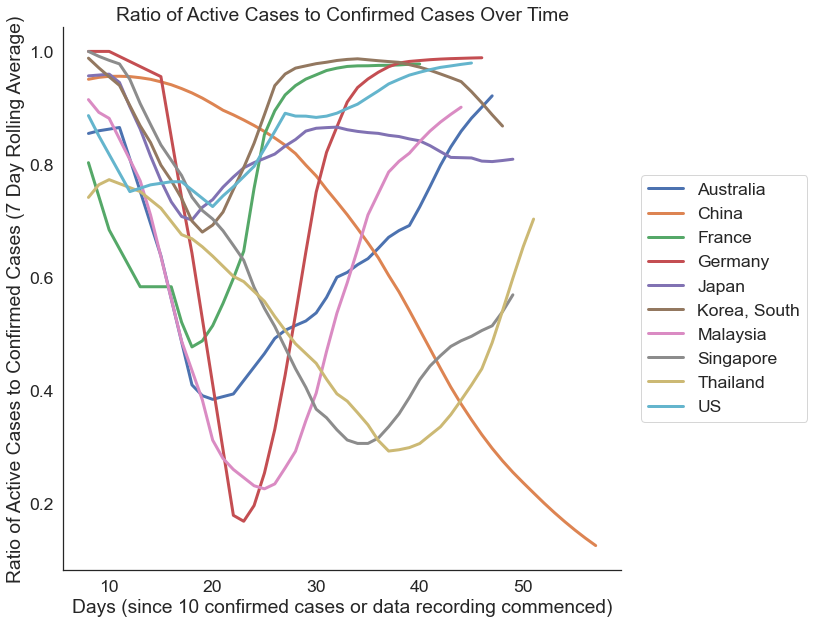

In [22]:
# Plot each country that has reported at least 30 days of data since 10 cases

sns.set(style='white')
sns.set_context('notebook', font_scale=1.6)

fig, ax = plt.subplots(figsize=(10,10))

for country in at_least_30_days:
    # Temporary DF of only confirmed cases per million and days since for each country
    to_plot = covid_cases.loc[:,(['active_confirmed_ratio_7day_rolling', 'days_since_ten'], country)].swaplevel(axis=1).droplevel('Country/Region', axis=1)
    # Plot only days after day 0 (10 cases)
    to_plot = to_plot[to_plot.days_since_ten > 7]
    ax.plot(to_plot['days_since_ten'], to_plot['active_confirmed_ratio_7day_rolling'], linewidth=3, label=country)

# Title and labels
ax.set_ylabel("Ratio of Active Cases to Confirmed Cases (7 Day Rolling Average)")
ax.set_xlabel("Days (since 10 confirmed cases or data recording commenced)")

ax.set_title("Ratio of Active Cases to Confirmed Cases Over Time")    

# Legend
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.02, 0.5))

# Aesthetics
sns.despine()
    
plt.show()

Utilising the formula deaths / (deaths + recovered) to estimate the case fatality rate (CFR) attempts to compensate for the unknown end point of cases by using only cases that have "completed" their illness (i.e. died or recovered). 
<br><br>
There are multiple assumptions made when using this method:
1. Cases die and recover at the same rate
    - This is rarely the case. As such, if cases die faster than they recover the CFR will be overestimated. Conversely, if cases generally recover faster than they die, it will be underestimated.
2. Reporting of recoveries and deaths is consistent
    - Not all countries regularly report recovered, but most report deaths, which may overestimate the CFR
3. Definition of recovery is consistent
    - Not all countries define "recovery" in the same manner
        - Two weeks post positive PCR without hospitalisation vs repeat negative PCR testing
4. The population tested does not vary over time
    - Early in the pandemic many countries only carried out "targetted" testing of patients with risk factors or those on hospital, rather than widespread community testing. This may result in the cases being detected early in the pandemic being more severe (more likely to be hospitalised) and more likely to die. While cases detected after the commencement of widespread testing are less likely to have been detected in hospitalised patients, thus reducing the incidence of mortality.

In [23]:
# Add columns for the estimated CFR

covid_cases = covid_cases.stack()
covid_cases['cfr_estimate'] = np.nan
covid_cases = covid_cases.unstack()

# Compute the estimated CFR and add it to the DF
covid_cases['cfr_estimate'] = covid_cases['deaths'] / (covid_cases['deaths'] + covid_cases['recovered'])

To attempt to maintain a degree of robustness, we will only analyse countries that have reported at least 50 confirmed COVID-19 cases.

In [24]:
# Make a list of all countries that have more than 50 cases to date

at_least_50 = []

for country in covid_cases['confirmed'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 50:
        at_least_50.append(country)

In [25]:
total_reporting = covid_cases['cfr_estimate'][at_least_50].iloc[-1].notna().sum()

print(f"As of the most recently reported data there are {total_reporting} countries with >50 confirmed cases in which the estimated CFR can be calculated.")

As of the most recently reported data there are 76 countries with >50 confirmed cases in which the estimated CFR can be calculated.


We can review the distribution of the estimated CFR (by country identified above) with summary statistics as well as visually using a histogram.

In [26]:
# Summary statistics of the estimated CFR

covid_cases['cfr_estimate'][at_least_50].iloc[-1].describe()

count    76.000000
mean      0.358562
std       0.374759
min       0.000000
25%       0.000000
50%       0.205263
75%       0.683611
max       1.000000
Name: 2020-03-19 00:00:00, dtype: float64

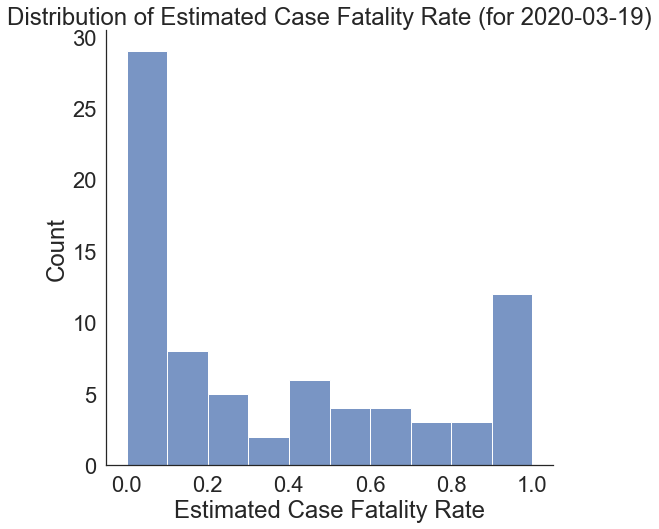

In [27]:
# Seaborn histplot of estimated CFR on the most recent date

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(data=covid_cases['cfr_estimate'][at_least_50].iloc[-1], bins=10, ax=ax)

ax.set_xlabel("Estimated Case Fatality Rate")
ax.set_title(f"Distribution of Estimated Case Fatality Rate (for {most_recent_date.date()})")

sns.despine()

plt.show()

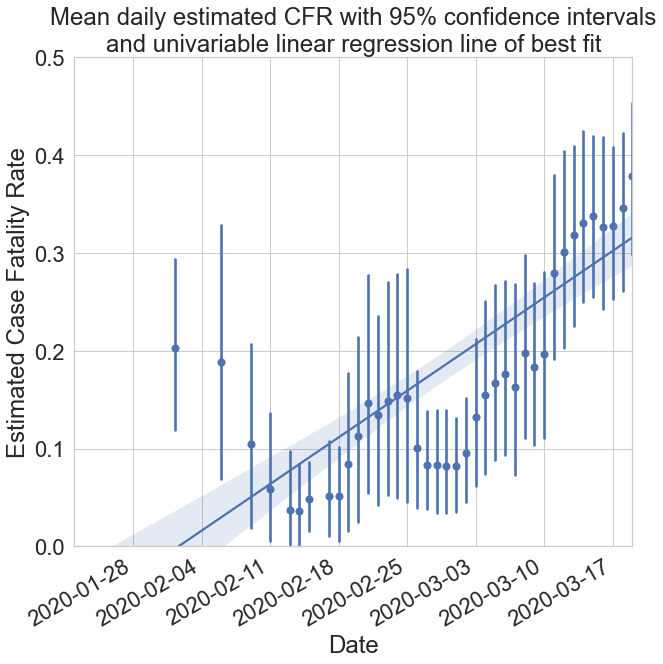

In [28]:
# Create a long form dataframe of just cfr_estimate irrespective of country and the date
cfr = covid_cases.unstack()['cfr_estimate'].droplevel(level=0).reset_index()
cfr.columns = ['date', 'cfr_estimate']

x = cfr['date']
y= cfr['cfr_estimate']

#Aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.update_units(x)

#Seaborn regplot with daily bins
sns.regplot(x=ax.xaxis.convert_units(x), y=y,
            x_bins=len(x.unique()),
            x_estimator=np.mean,
            x_ci='ci',
            ci=95,
            n_boot=1000,
            truncate=True,
            ax=ax)

# Major ticks every 7 Days.
fmt_week = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_week)

ax.set_ylim(0,0.5)

ax.set_xlabel("Date")
ax.set_ylabel("Estimated Case Fatality Rate")
ax.set_title("Mean daily estimated CFR with 95% confidence intervals\nand univariable linear regression line of best fit")

#Make the date ticks look right
fig.autofmt_xdate()

plt.show()

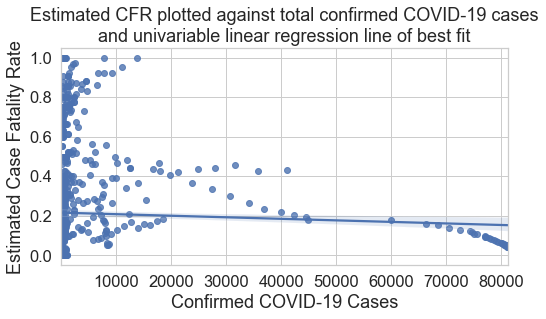

In [29]:
# Create a long format DF of confirmed COVID-19 cases to match the earlier created long formate cfr_estimate DF
confirmed = covid_cases.unstack()['confirmed'].droplevel(level=0).reset_index()
confirmed.columns = ['date', 'confirmed']

x = confirmed['confirmed']
y= cfr['cfr_estimate']

# Aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,4))

# Seaborn regplot
sns.regplot(x=x, y=y,
            n_boot=1000,
            truncate=True,
            ax=ax)

ax.set_xlabel("Confirmed COVID-19 Cases")
ax.set_ylabel("Estimated Case Fatality Rate")
ax.set_title("Estimated CFR plotted against total confirmed COVID-19 cases\nand univariable linear regression line of best fit")

plt.show()

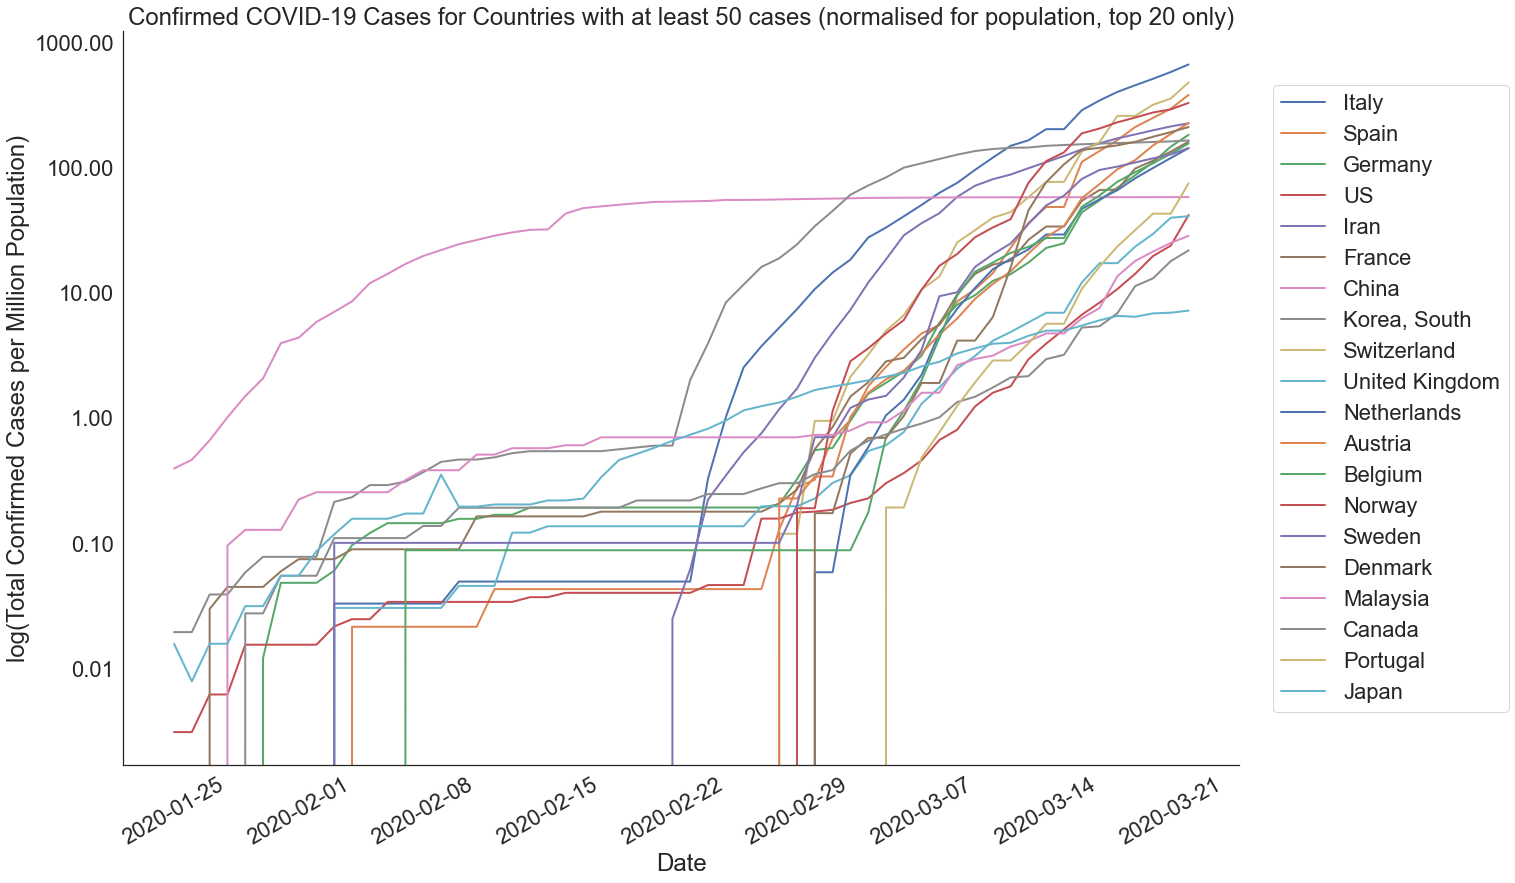

In [30]:
from matplotlib.ticker import FormatStrFormatter
# Make a list of all countries that have more than 50 cases to date

at_least_50 = []

for country in covid_cases['confirmed'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 50:
        at_least_50.append(country)
        
top_20 = covid_cases.loc[most_recent_date]['active'][at_least_50].T.sort_values(ascending=False)[:20].index
        
# Plot each country that has more than 50 cases to date

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(20,15))

for country in top_20:
    # Temporary DF of only confirmed cases per million for each country
    to_plot = covid_cases.loc[:,(['confirmed_per_million'], country)].swaplevel(axis=1).droplevel('Country/Region', axis=1)
    ax.plot(to_plot, linewidth=2, label=country)

# Log scale for the y axis (makes it more interpretable between countries early in the pandemic)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Title and labels
ax.set_ylabel("log(Total Confirmed Cases per Million Population)")
ax.set_xlabel("Date")

ax.set_title("Confirmed COVID-19 Cases for Countries with at least 50 cases (normalised for population, top 20 only)")

# Legend
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.02, 0.5))

# Major ticks every 7 Days.
fmt_week = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_week)

#Make the date ticks look right
fig.autofmt_xdate()

# Aesthetics
sns.despine()

plt.show()

\subsection{Optional: For each of the last five weeks, create a global map showing the rate of increase in the number of confirmed cases over that week. Create similar maps for the rate of increase in the number of active cases.}

C:\Users\mrevi\anaconda3\lib\site-packages\matplotlib\colors.py:1396: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0
C:\Users\mrevi\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


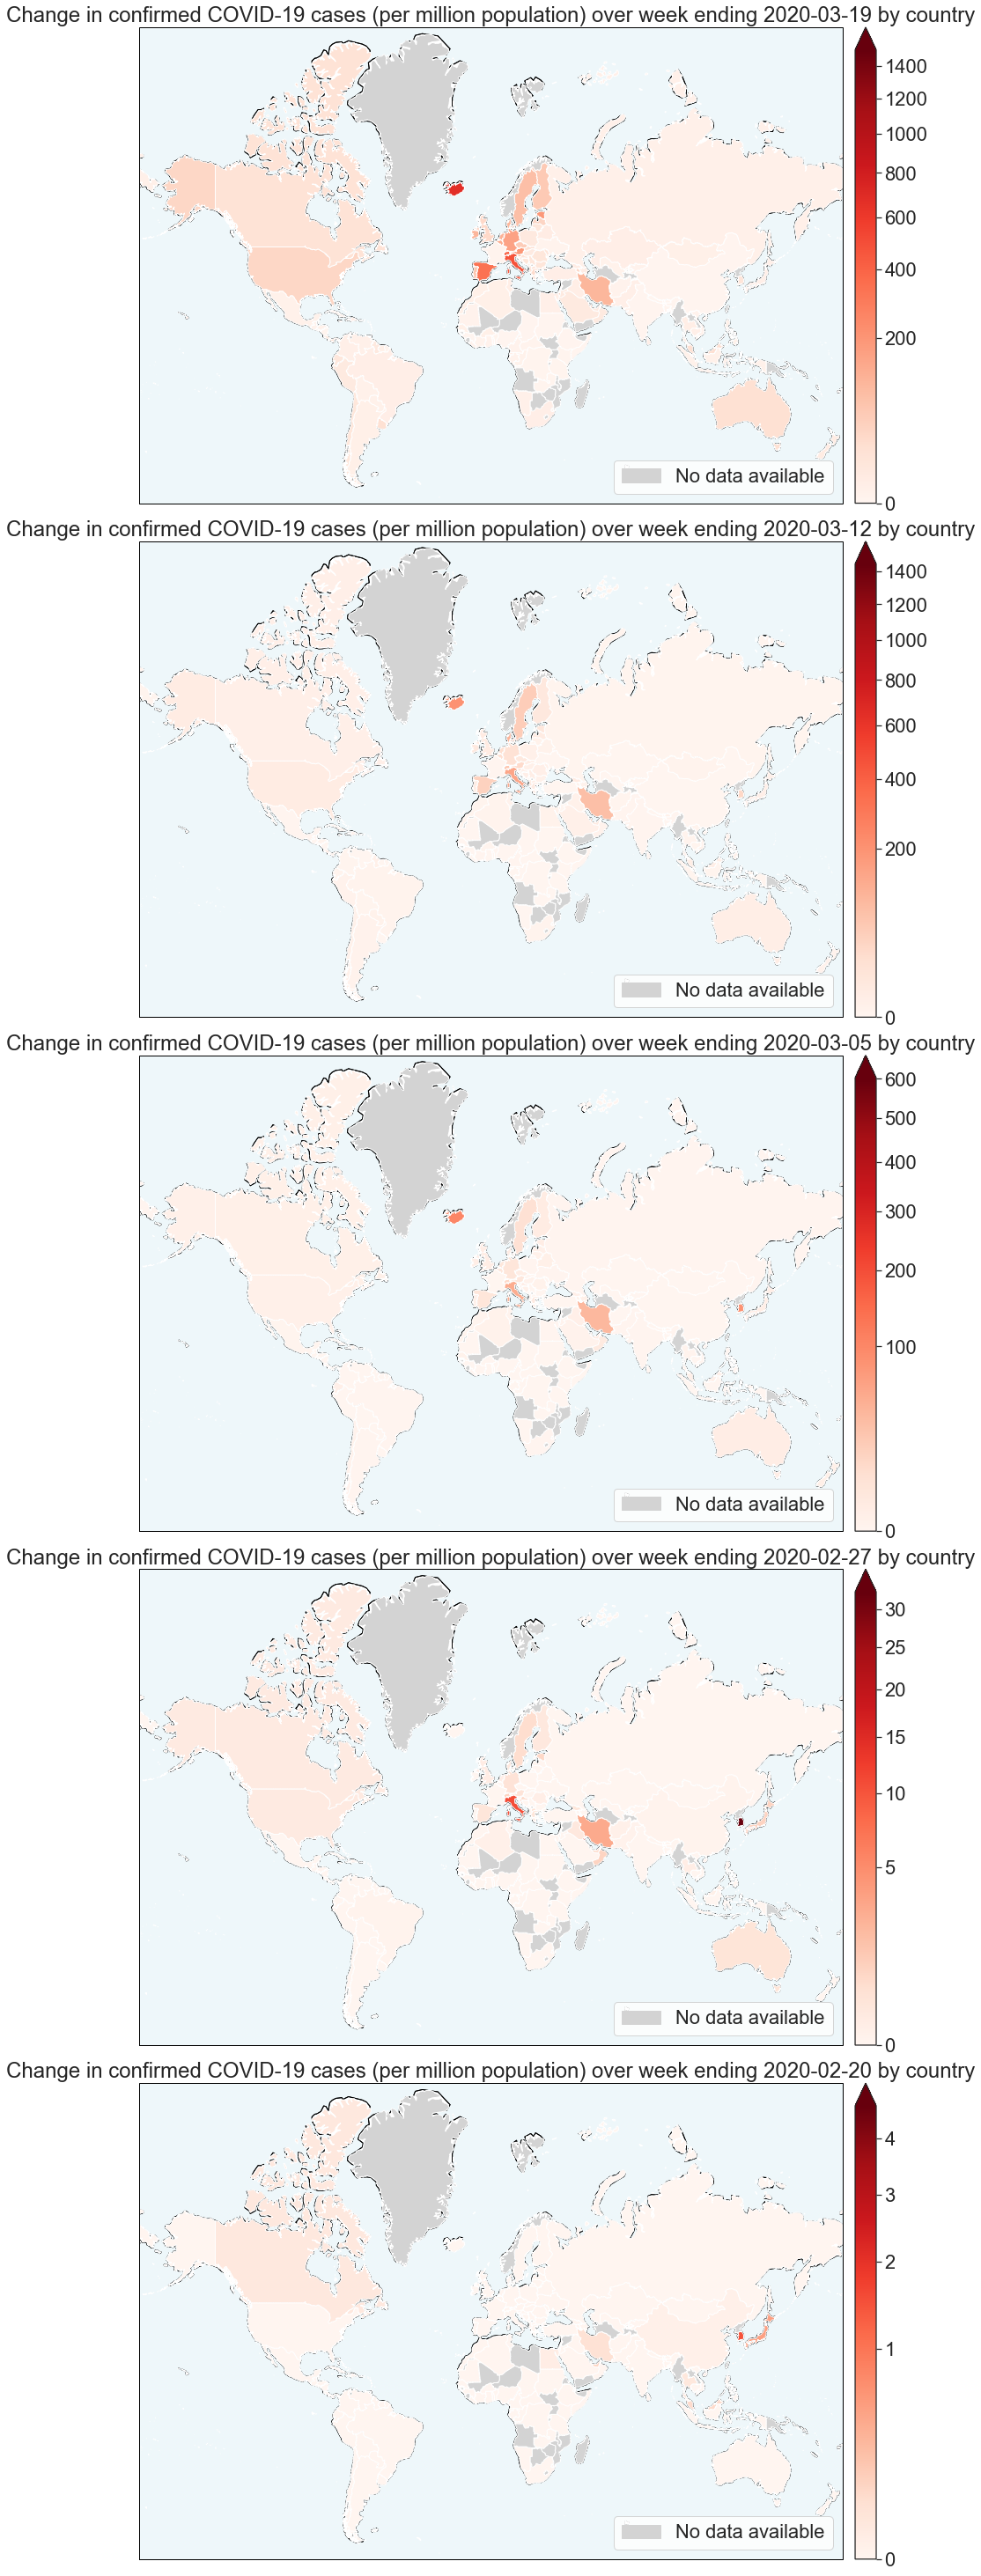

In [31]:
projection = ccrs.Mercator()
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(15,60))

# Create and axes grid for each of the 5 maps (one for each week of data)
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(5, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

# Download the shape/polygon data for each country from the natural earth database
shpfilename = shapereader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')
reader = shapereader.Reader(shpfilename)

# Iterate through each subplot
for i, (ax, cax) in enumerate(zip(axgr, axgr.cbar_axes)):
    
    # Generate the list of country data (unfortunately this seems to need to be generated each iteration)
    countries = reader.records()
    
    # Add the base map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cfeature.OCEAN, facecolor=("lightblue"), alpha=0.2)
    ax.set_extent([-180,180,-60,86], crs=ccrs.PlateCarree())
    ax.coastlines()
    
    #Create a DF for the week being plotted to store the absolute change in cases
    week_change = pd.DataFrame(index=country_codes.Country_Code.unique(), columns=['Country', 'week_change'])
    
    # Calculate the change in cases for the week being plotted
    for country in covid_cases['confirmed'].columns:
        code = country_codes[country_codes.Country == country].Country_Code.iloc[0]
        week_end = most_recent_date - timedelta(days=(7*i))
        week_start = week_end - timedelta(days=7)
        week_end_confirmed = covid_cases.loc[week_end, ('confirmed_per_million', country)].item()
        week_start_confirmed = covid_cases.loc[week_start, ('confirmed_per_million', country)].item()
        week_change.loc[code, 'week_change'] = (week_end_confirmed - week_start_confirmed)
    
    # Set the normalisation function for the week change data and add a column of normalised values
    # This will allow us to plot each countries colour in a reproducible way and have a scaled colourbar on the side
    norm = mpl.colors.PowerNorm(vmin=np.nanmin(week_change.week_change), vmax=np.nanmax(week_change.week_change), gamma=0.5)
    week_change['week_change_norm'] = norm(week_change.week_change)
    
    # Choose your colourmap
    cmap = mpl.cm.get_cmap('Reds')
    
    ax.set_title(f"Change in confirmed COVID-19 cases (per million population) over week ending {week_end.date()} by country")
    
    # Iterate through each country and if we have data for it, add the geometry to the map and colour it appropriately
    for country in countries:
        if country_codes.Country_Code.str.contains(country.attributes['ISO_A3_EH']).any():
            code = country.attributes['ISO_A3_EH']
            if pd.notna(week_change.loc[code, 'week_change']):
                rgba = cmap(week_change.loc[code,'week_change_norm'])
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=rgba)
            else: # If null value in week change then fill country with gray
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')
        else: # If no matching country code then fill country with gray
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')

    # Scale our colourbar appropriately for each week of data
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = cax.colorbar(sm, extend='max')
    
    # Add a legend demonstrating that gray means no data
    grey_patch = mpatches.Patch(color='lightgrey', label='No data available')
    ax.legend(handles=[grey_patch], loc='lower right')
    
plt.show()

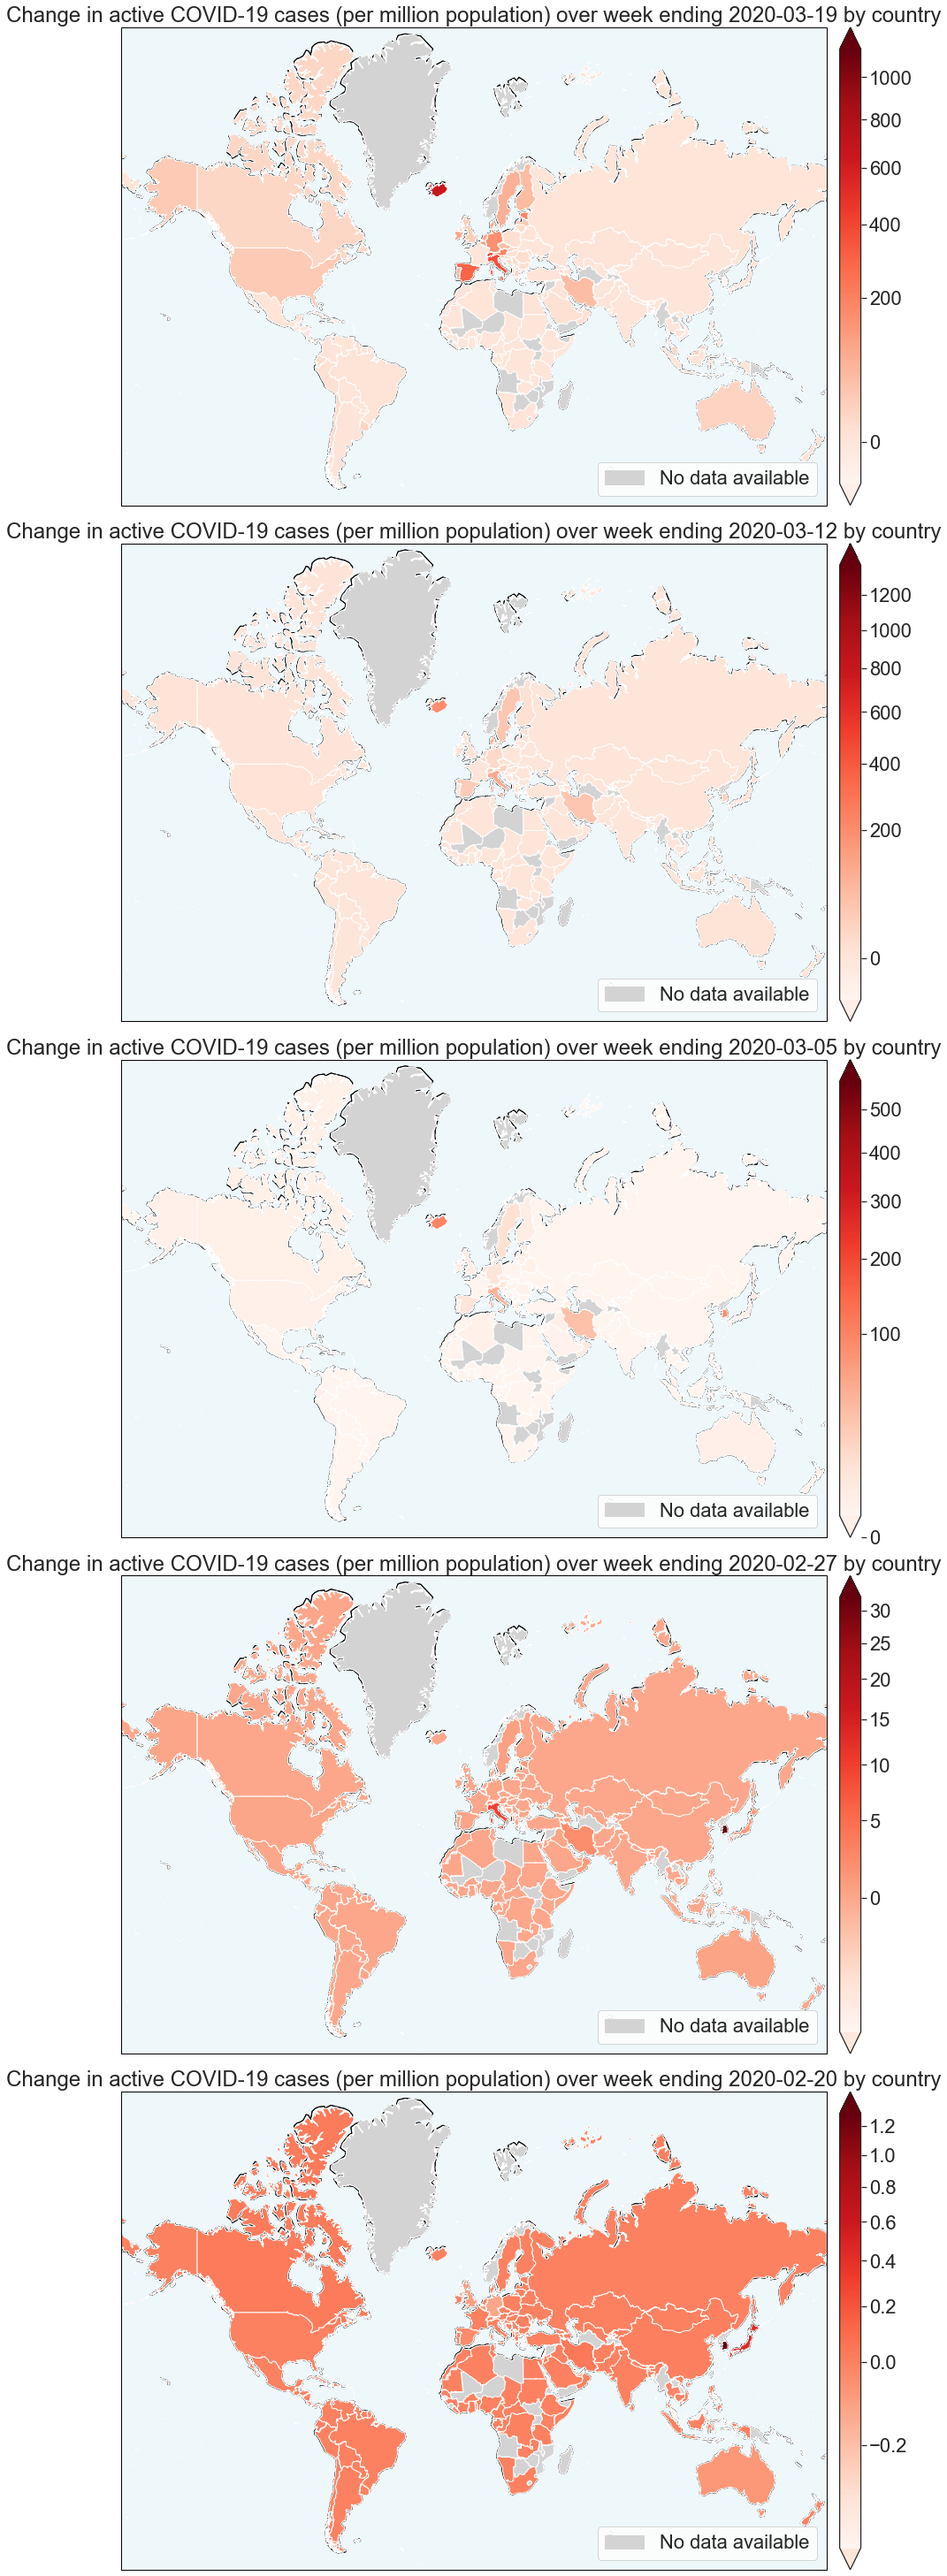

In [32]:
projection = ccrs.Mercator()
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(15,60))

# Create and axes grid for each of the 5 maps (one for each week of data)
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(5, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

# Download the shape/polygon data for each country from the natural earth database
shpfilename = shapereader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')
reader = shapereader.Reader(shpfilename)

# Iterate through each subplot
for i, (ax, cax) in enumerate(zip(axgr, axgr.cbar_axes)):
    
    # Generate the list of country data (unfortunately this seems to need to be generated each iteration)
    countries = reader.records()
    
    # Add the base map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cfeature.OCEAN, facecolor=("lightblue"), alpha=0.2)
    ax.set_extent([-180,180,-60,86], crs=ccrs.PlateCarree())
    ax.coastlines()
    
    #Create a DF for the week being plotted to store the absolute change in cases
    week_change = pd.DataFrame(index=country_codes.Country_Code.unique(), columns=['Country', 'week_change'])
    
    # Calculate the change in cases for the week being plotted
    for country in covid_cases['confirmed'].columns:
        code = country_codes[country_codes.Country == country].Country_Code.iloc[0]
        week_end = most_recent_date - timedelta(days=(7*i))
        week_start = week_end - timedelta(days=7)
        week_end_confirmed = covid_cases.loc[week_end, ('active_per_million', country)].item()
        week_start_confirmed = covid_cases.loc[week_start, ('active_per_million', country)].item()
        week_change.loc[code, 'week_change'] = (week_end_confirmed - week_start_confirmed)
    
    #week_change = week_change[week_change.week_change.notna()].astype(float)
    
    # Set the normalisation function for the week change data and add a column of normalised values
    # This will allow us to plot each countries colour in a reproducible way and have a scaled colourbar on the side
    norm = mpl.colors.PowerNorm(vmin=np.nanmin(week_change.week_change), vmax=np.nanmax(week_change.week_change), gamma=0.5)
    week_change['week_change_norm'] = norm(week_change.week_change.astype('float'))
    
    # Choose your colourmap
    cmap = mpl.cm.get_cmap('Reds')
    
    ax.set_title(f"Change in active COVID-19 cases (per million population) over week ending {week_end.date()} by country")
    
    # Iterate through each country and if we have data for it, add the geometry to the map and colour it appropriately
    for country in countries:
        if week_change.index.str.contains(country.attributes['ISO_A3_EH']).any():
            code = country.attributes['ISO_A3_EH']
            if pd.notna(week_change.loc[code, 'week_change']):
                rgba = cmap(week_change.loc[code,'week_change_norm'])
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=rgba)
            else: # If null value in week change then fill country with gray
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')
        else: # If no matching country code then fill country with gray
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')

    # Scale our colourbar appropriately for each week of data
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = cax.colorbar(sm, extend='both')
    
    # Add a legend demonstrating that gray means no data
    grey_patch = mpatches.Patch(color='lightgrey', label='No data available')
    ax.legend(handles=[grey_patch], loc='lower right')
    
plt.show()

\subsection{Optional: Create a map to visualise the results of your 'mitigation' analysis (fourth question of the previous section).}

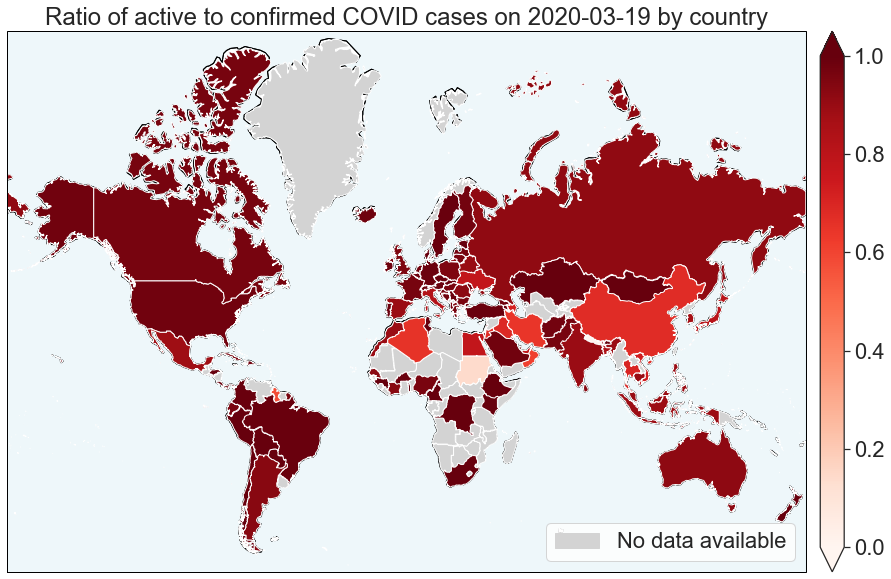

In [33]:
projection = ccrs.Mercator()
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(15,15))

# Create and axes grid for each of the 5 maps (one for each week of data)
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

# Download the shape/polygon data for each country from the natural earth database
shpfilename = shapereader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')
reader = shapereader.Reader(shpfilename)

# Iterate through each subplot
for i, (ax, cax) in enumerate(zip(axgr, axgr.cbar_axes)):
    
    # Generate the list of country data (unfortunately this seems to need to be generated each iteration)
    countries = reader.records()
    
    # Add the base map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cfeature.OCEAN, facecolor=("lightblue"), alpha=0.2)
    ax.set_extent([-180,180,-60,86], crs=ccrs.PlateCarree())
    ax.coastlines()
    
    #Create a DF for the week being plotted to store the absolute change in cases
    week_change = pd.DataFrame(index=country_codes.Country_Code.unique(), columns=['active_confirmed_ratio_7day_rolling'])
    
    # Calculate the change in cases for the week being plotted
    for country in covid_cases['confirmed'].columns:
        code = country_codes[country_codes.Country == country].Country_Code.iloc[0]
        week_change.loc[code, 'active_confirmed_ratio_7day_rolling'] = covid_cases.loc[most_recent_date, ('active_confirmed_ratio_7day_rolling', country)].item()
    
    #week_change = week_change[week_change.week_change.notna()].astype(float)
    
    # Set the normalisation function for the week change data and add a column of normalised values
    # This will allow us to plot each countries colour in a reproducible way and have a scaled colourbar on the side
    norm = mpl.colors.Normalize(vmin=np.nanmin(week_change.active_confirmed_ratio_7day_rolling), vmax=np.nanmax(week_change.active_confirmed_ratio_7day_rolling))
    cfr_norm = norm(week_change.active_confirmed_ratio_7day_rolling.astype('float'))
    
    # Choose your colourmap
    cmap = mpl.cm.get_cmap('Reds')
    
    ax.set_title(f"Ratio of active to confirmed COVID cases on {most_recent_date.date()} by country")
    
    # Iterate through each country and if we have data for it, add the geometry to the map and colour it appropriately
    for country in countries:
        if country_codes.Country_Code.str.contains(country.attributes['ISO_A3_EH']).any():
            code = country.attributes['ISO_A3_EH']
            if pd.notna(week_change.loc[code, 'active_confirmed_ratio_7day_rolling']):
                rgba = cmap(week_change.loc[code,'active_confirmed_ratio_7day_rolling'])
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=rgba)
            else: # If null value in week change then fill country with gray
                ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')
        else: # If no matching country code then fill country with gray
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')

    # Scale our colourbar appropriately for each week of data
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = cax.colorbar(sm, extend='both')
    
    # Add a legend demonstrating that gray means no data
    grey_patch = mpatches.Patch(color='lightgrey', label='No data available')
    ax.legend(handles=[grey_patch], loc='lower right')
    
plt.show()

\section{Concluding remarks}